- it's debatable whether this topic even qualifies as "deep learning" because we're going to see how to build a pretty good recommender system without using a neural network at all! We will, however, take advantage of the power of a modern computation framework like Keras to implement the recommender with minimal code. We'll try a couple different approaches using a technique called collaborative filtering. Finally we'll build a true neural network and see how it compares to the collaborative filtering approach.

- neural network(신경망) 같은 딥러닝을 쓰지 않아도 꽤 좋은 추천 시스템을 만들 수 있다. 그렇다면, 딥러닝은 왜 쓰는가?
- 더 코드가 단순하다!
- 더 많은 데이터를 사용할 수 있다!

## Collaborative Filtering(CF)
- 전처리 과정

출처 : https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv( 'new_df.csv')
df.head()

,Unnamed: 0,beer_id,username,look,smell,taste,feel,overall,score
0,0,271781,bluejacket74,4.00,4.00,4.0,4.25,4.00,4.03
1,9449,78043,bluejacket74,3.50,4.00,3.5,3.50,3.50,3.62
2,10982,225791,bluejacket74,4.25,4.00,4.0,3.75,4.00,3.99
3,17441,77030,bluejacket74,3.50,3.75,4.0,3.75,3.75,3.84
4,18672,47658,bluejacket74,4.50,5.00,5.0,5.00,5.00,4.97


In [3]:
print(df.shape) #중간발표 때 1차 전처리를 했던 440만개의 데이터를 활용하였다.

(4403885, 9)


In [4]:
#잠깐 전처리

cols = ['beer_id','username','score']
df = df[cols]

In [30]:
df.rename(columns = {'beer_id':'beerid','username':'userid','score':'rating'}, inplace = True)
df.head()

,beerid,userid,rating,userId
0,271781,bluejacket74,4.03,0
1,78043,bluejacket74,3.62,0
2,225791,bluejacket74,3.99,0
3,77030,bluejacket74,3.84,0
4,47658,bluejacket74,4.97,0


In [34]:
#top 15 users, top 15 movies -> table

g = df.groupby('userid')['rating'].count() #유저아이디별로, rating을 몇 개를 주었는가?
top_users = g.sort_values(ascending=False)[:15] #rating을 많이 한 유저 상위 15명

g = df.groupby('beerid')['rating'].count() #beer아이디별로, rating은 몇 개인가?
top_beers = g.sort_values(ascending=False)[:15] #rating이 많은 상위 맥주 15개

top_r = df.join(top_users, rsuffix='_r', how='inner', on='userid') #ratings df에 top_users join
top_r = top_r.join(top_beers, rsuffix='_r', how='inner', on='beerid') #위에서 만든 df에 top_movies join

pd.crosstab(top_r.userid, top_r.beerid, top_r.rating, aggfunc=np.sum)

beerid,88,276,412,1093,1708,1904,2093,7971,10672,11757,17112,19960,29619,34483,89174
userid,,,,,,,,,,,,,,,
BEERchitect,4.28,4.42,4.45,4.55,4.80,4.18,4.27,4.55,4.82,4.45,4.63,4.84,4.34,4.23,4.27
Knapp85,4.00,3.68,4.53,4.27,4.47,3.75,4.45,4.65,4.17,4.50,4.57,4.67,4.42,4.35,4.27
Sammy,3.80,3.75,3.83,4.30,4.20,4.08,4.05,4.15,4.23,4.27,3.80,4.00,4.22,4.18,3.73
StonedTrippin,4.30,3.72,3.70,4.32,4.32,4.21,4.25,4.52,4.42,4.10,4.09,4.54,4.48,4.18,4.30
UCLABrewN84,4.23,4.20,4.48,4.17,4.47,3.72,3.03,4.95,4.77,4.45,4.39,4.74,4.21,4.50,3.89
acurtis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.10,NaN,NaN,NaN,NaN,4.09,NaN,3.85
biboergosum,4.42,4.12,4.15,3.95,4.30,4.03,4.23,4.27,4.19,4.15,4.00,4.33,4.13,4.34,4.36
brentk56,4.23,3.79,4.13,4.50,4.53,4.27,4.82,4.46,4.45,4.85,4.47,4.21,4.50,4.38,4.40
emerge077,4.15,NaN,NaN,4.33,4.42,4.28,3.83,4.30,4.60,4.33,4.33,4.42,4.30,4.33,4.13


## LabelEncoder
- user/beer 컬럼은 지금은 non-sequentail integer이다. 그러므로 unique ID를 나타내는 것으로 value를 바꿔주어야 한다.
- 이 때 이용하는 것이 바로 'labelencoder()' <-발표자료에는 이것의 설명도 추가.(캡처확인)
- 이를 이용하면 모델링을 위해, 변수의 value를 0부터 시작되는 숫자로 바꿀 수 있다. (숫자->숫자도 되고 문자->숫자도 된다.)

In [36]:
#딥러닝에 이용할 컬럼 변경: user, beer, rating

user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['userid'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['beer'] = item_enc.fit_transform(df['beerid'].values)
n_beers = df['beer'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

n_users, n_beers, min_rating, max_rating #n_users, n_beers: 유니크한 값 개수, rating의 최솟값과 최댓값.

(9012, 154711, 1.0, 5.0)

In [38]:
df.head() #완료된 데이터셋. 여기서 'user','beer','rating'만 사용

,beerid,userid,rating,userId,user,beer
0,271781,bluejacket74,4.03,0,5227,129595
1,78043,bluejacket74,3.62,0,5227,43239
2,225791,bluejacket74,3.99,0,5227,112870
3,77030,bluejacket74,3.84,0,5227,42548
4,47658,bluejacket74,4.97,0,5227,24908


In [39]:
#train, test 셋 분할: test size는 0.3, random_state는 임의로 지정

X = df[['user', 'beer']].values
y = df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3082719, 2), (1321166, 2), (3082719,), (1321166,))

In [40]:
#딥러닝 모델을 만들 때 필요한 또다른 변수는: 잠재요인의 개수를 정하는 것!
#잠재요인의 개수는 원하는 대로 설정하면 되지만, 주의할 것은 user와 beer 모두에 대해 같은 사이즈를 줘야 한다는 점.

#우리는 50개로 간다!(X에 대해서만 적용)
n_factors = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [41]:
#keras 라이브러리 로드
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


# Recommdation System using Keras 
- 각 유저와 각 맥주를 나타내기 위해 'embedding'이라는 것을 활용한다.->(설명부분 캡처)
- 'embeddings'는 벡터이다(n_factor 사이즈의). 시작은 랜덤한 숫자로 가고, 각 유저/맥주의 필수적인 특징을 잡으면 fit model을 해보자.
- fit model 과정) 유저 벡터와 맥주 벡터를 스칼라곱(dot product)하여 예측 평점을 계산함.
- 이를 위해선 유니크한 유저 수와 맥주 수가 필요, -> 각각의 embedding matrix의 사이즈를 정의하기 위함.

- Now we get to the model itself. The main idea here is we're going to use embeddings to represent each user and each movie in the data. These embeddings will be vectors (of size n_factors) that start out as random numbers but are fit by the model to capture the essential qualities of each user/movie. We can accomplish this by computing the dot product between a user vector and a movie vector to get a predicted rating. The code is fairly simple, there isn't even a traditional neural network layer or activation involved. I stuck some regularization on the embedding layers and used a different initializer but even that probably isn't necessary. Notice that this is where we need the number of unique users and movies, since those are required to define the size of each embedding matrix.

## RecommenderV1 함수
- input : n_users(# of unique users), n_beers(# of uniuqe beers), n_factors(잠재요인 수)
- 이 함수를 사용하면 예측평점 계산하기가 아주 간편하다.(역시 계산이 간단한 딥러닝^-^)

- 참고(케라스 사전: embedding): https://keras.io/layers/embeddings/

In [59]:
def RecommenderV1(n_users, n_beers, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    #embedding initializer로는 he_normal 사용: normal dist'n
    #embeddings_regularizer로는 
    u = Reshape((n_factors,))(u)
    
    beer = Input(shape=(1,))
    m = Embedding(n_beers, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(beer)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])

    model = Model(inputs=[user, beer], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

In [60]:
model = RecommenderV1(n_users, n_beers, n_factors)
model.summary()

#Below you can see that all of the parameters are in the embedding layers, 
#we don't have any traditional neural net components at all.

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        450600      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        7735550     input_6[0][0]                    
____________________________________________________________________________________________

## 모델 train셋에 학습
<주요 인자> model.fit(x, y, batch_size=32, epochs=10)
- x: 입력 데이터
- y: 라벨 값
- batch_size : 몇 개의 샘플로 가중치를 갱신할 것인지 지정 (작을수록 가중치 갱신이 자주 일어남, 더 업데이트를 많이 하게 됨.)
- epochs : 학습 반복의 횟수 (클수록 학습을 많이 하므로 정확도가 높아지지만, 너무 크면 과적합의 가능성)
- 참고) https://tykimos.github.io/2017/03/25/Fit_Talk/ 설명 잘나와있음!

In [61]:
#우리의 X_train의 개수는 308만개, X_test의 개수는 132만개이므로 만개를 batch_size로 설정함.
hist1 = model.fit(x=X_train_array, y=y_train, batch_size=10000, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 3082719 samples, validate on 1321166 samples
Epoch 1/5
3082719/3082719 [==============================] - 68s 22us/step - loss: 11.4058 - val_loss: 4.0669
Epoch 2/5
3082719/3082719 [==============================] - 57s 18us/step - loss: 2.3264 - val_loss: 1.5333
Epoch 3/5
3082719/3082719 [==============================] - 58s 19us/step - loss: 1.0717 - val_loss: 0.9651
Epoch 4/5
3082719/3082719 [==============================] - 83s 27us/step - loss: 0.6941 - val_loss: 0.7404
Epoch 5/5
3082719/3082719 [==============================] - 71s 23us/step - loss: 0.5389 - val_loss: 0.6342


## RecommenderV2 함수
- 각각의 embedding에 'bias'를 추가해보자.


In [77]:
#I also refactored the code a bit by pulling out the embedding layer 
# and reshape operation into a separate class.

from keras.layers import Add, Activation, Lambda

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderV2(n_users, n_beers, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    beer = Input(shape=(1,))
    m = EmbeddingLayer(n_beers, n_factors)(beer)
    mb = EmbeddingLayer(n_beers, 1)(beer)

    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, beer], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

In [78]:
model = RecommenderV2(n_users, n_beers, n_factors, min_rating, max_rating)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 50)        450600      input_7[0][0]                    
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 50)        7735550     input_8[0][0]                    
____________________________________________________________________________________________

In [79]:
hist2 = model.fit(x=X_train_array, y=y_train, batch_size=10000, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 3082719 samples, validate on 1321166 samples
Epoch 1/5
3082719/3082719 [==============================] - 93s 30us/step - loss: 0.6064 - val_loss: 0.2325
Epoch 2/5
3082719/3082719 [==============================] - 76s 25us/step - loss: 0.1977 - val_loss: 0.1863
Epoch 3/5
3082719/3082719 [==============================] - 85s 28us/step - loss: 0.1740 - val_loss: 0.1781
Epoch 4/5
3082719/3082719 [==============================] - 69s 22us/step - loss: 0.1672 - val_loss: 0.1746
Epoch 5/5
3082719/3082719 [==============================] - 68s 22us/step - loss: 0.1632 - val_loss: 0.1721


## 모델의 학습과정 살펴보기
- 참고) https://tykimos.github.io/2017/07/09/Training_Monitoring/
- https://snowdeer.github.io/machine-learning/2018/01/11/keras-use-history-function/

In [80]:
score = model.evaluate(X_test_array, y_test, batch_size =10000)
score
#print('')
#print('loss : ' + str(score[0]))
#print('accuray : ' + str(score[1]))

1321166/1321166 [==============================] - 4s 3us/step



TypeError: 'float' object is not subscriptable

In [81]:
history_dict = hist2.history
history_dict.keys()

dict_keys(['val_loss', 'loss'])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist2.history['loss'], 'y', label='train loss')
loss_ax.plot(hist2.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist2.history['acc'], 'b', label='train acc')
acc_ax.plot(hist2.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## RecommenderNet

In [86]:
from keras.layers import Concatenate, Dense, Dropout

def RecommenderNet(n_users, n_beers, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    beer = Input(shape=(1,))
    m = EmbeddingLayer(n_beers, n_factors)(beer)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, beer], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

In [87]:
model = RecommenderNet(n_users, n_beers, n_factors, min_rating, max_rating)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 50)        450600      input_11[0][0]                   
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 50)        7735550     input_12[0][0]                   
____________________________________________________________________________________________

In [ ]:
hist3 = model.fit(x=X_train_array, y=y_train, batch_size=5000, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 3082719 samples, validate on 1321166 samples
Epoch 1/5
3082719/3082719 [==============================] - 176s 57us/step - loss: 0.1621 - val_loss: 0.1394
Epoch 2/5
3082719/3082719 [==============================] - 125s 40us/step - loss: 0.1572 - val_loss: 0.1395
Epoch 3/5
1695000/3082719 [===============>..............] - ETA: 56s - loss: 0.1544

In [94]:
history_dict = hist3.history
history_dict.keys() #근데 왜 acc가 없을까?
#history_dict.values()

dict_keys(['val_loss', 'loss'])

In [91]:
score = model.evaluate(X_test_array, y_test, batch_size =5000)
score

#10000으로 했을 때의 score : 0.13701472737170253
#5000으로 했을 때의 score: 

1321166/1321166 [==============================] - 4s 3us/step


0.13701472737170253

KeyError: 'acc'

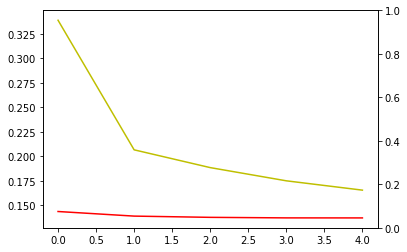

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist3.history['loss'], 'y', label='train loss')
loss_ax.plot(hist3.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist3.history['acc'], 'b', label='train acc')
acc_ax.plot(hist3.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [113]:
#예측 결과 비교

pred = pd.DataFrame(model.predict(X_test_array, batch_size=10000), columns=['pred'])
actual = pd.DataFrame(y_test, columns=['actual'])

In [115]:
result = pd.concat( [pred, actual], axis = 1)
result.head()

,pred,actual
0,4.194257,4.22
1,3.518090,2.59
2,3.592885,3.63
3,3.752315,3.68
4,3.806270,3.97


In [133]:
result['diff'] = result['pred'] - result['actual']

result.head(15)

,pred,actual,diff
0,4.194257,4.22,-0.025743
1,3.518090,2.59,0.928090
2,3.592885,3.63,-0.037115
3,3.752315,3.68,0.072315
4,3.806270,3.97,-0.163730
5,4.210329,4.02,0.190329
6,4.054770,4.00,0.054770
7,3.503155,3.71,-0.206845
8,3.824488,4.00,-0.175512
9,3.159501,3.28,-0.120499


In [118]:
np.mean(result['diff'])

-0.013670957

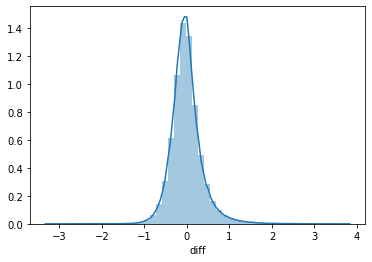

In [129]:
import seaborn as sns
sns.distplot(result['diff'])
plt.show()

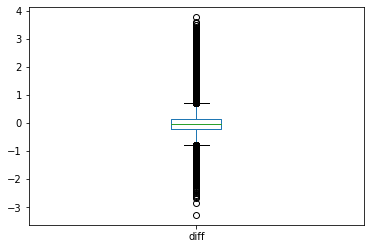

In [127]:
result['diff'].plot(kind='box')

In [131]:
#일표본 t-검정 #0으로 볼 수는 없음
from scipy import stats
diff = result['diff']  
res= stats.ttest_1samp(diff, 0) 
print('t statistic : %.3f \np-value : %.3f' % (res))

t statistic : -43.197 
p-value : 0.000
